In [59]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
%matplotlib inline
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import chart_studio.plotly as py
import numpy as np
import datetime as datetime
from datetime import date, timedelta
import requests
import io
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
from IPython.display import Markdown as md
import math
# Function for displaying the map
def embed_map(m, file_name):
    from IPython.display import IFrame
    m.save(file_name)
    return IFrame(file_name, width='100%', height='700px')

We define a function to get the raw data from the corresponding url and retruning it as a dataframe.
<br>This function allows us to get the latest updates.

In [2]:
def get_raw_data(url):
    req = requests.get(url).content
    return pd.read_csv(io.StringIO(req.decode('utf-8')))

# Worldwide Analysis

Import the latest reports from CSSE at Johns Hopkins University.
<br> Date of the latest data to be gathered is "yesterday" to ensure the data is available as the files are updated daily at midnight.
<br> We use the date variable "yesterday" to build the urls dynamically.

In [3]:
yesterday = date.today() - timedelta(days=1)
yesterday = yesterday.strftime("%m-%d-%Y") 

In [4]:
world_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{}.csv".format(yesterday)
confirmed_w_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
fatalities_w_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv"
recovered_w_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv"
da_world = get_raw_data(world_url)
da_confirmed_w = get_raw_data(confirmed_w_url)
da_fatalities_w = get_raw_data(fatalities_w_url)
da_recovered_w = get_raw_data(recovered_w_url)

First look at the overall data. 

In [5]:
da_world.head(5)

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude
0,Hubei,China,2020-03-19T10:13:14,67800,3130,57682,30.9756,112.2707
1,NaN,Italy,2020-03-19T17:43:03,41035,3405,4440,41.8719,12.5674
2,NaN,Iran,2020-03-19T11:33:29,18407,1284,5710,32.4279,53.6880
3,NaN,Spain,2020-03-19T20:13:08,17963,830,1107,40.4637,-3.7492
4,NaN,Germany,2020-03-19T20:13:08,15320,44,113,51.1657,10.4515


We rename the entries for South Korea.

In [6]:
da_world["Country/Region"] = da_world["Country/Region"].replace("Korea, South","South Korea")
da_confirmed_w["Country/Region"] = da_confirmed_w["Country/Region"].replace("Korea, South","South Korea")
da_fatalities_w["Country/Region"] = da_fatalities_w["Country/Region"].replace("Korea, South","South Korea")
da_recovered_w["Country/Region"] = da_recovered_w["Country/Region"].replace("Korea, South","South Korea")

Consolidate the name of Republic of Congo for all possible variants.

In [8]:
list_congo = da_world[da_world["Country/Region"].str.contains("Congo")].index
for x in list_congo:
    da_world.loc[x,"Country/Region"] = "Republic of the Congo"
da_world[da_world["Country/Region"].str.contains("Congo")]

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude
192,NaN,Republic of the Congo,2020-03-19T10:53:03,14,0,0,-4.0383,21.7587
233,NaN,Republic of the Congo,2020-03-19T20:13:56,3,0,0,-0.2280,15.8277
289,NaN,Republic of the Congo,2020-03-17T21:33:03,0,0,0,-1.4400,15.5560


We add a column for the active positive cases. 
<br>Our main interest is to see how the numbers of active cases are changing. 

In [9]:
da_world["Active"] = da_world["Confirmed"] - da_world["Recovered"] - da_world["Deaths"]

## Global numbers in a nutshell

In [10]:
total_w = da_world[["Confirmed","Active","Recovered","Deaths"]].sum()
total_w

Confirmed    242713
Active       147884
Recovered     84962
Deaths         9867
dtype: int64

We group the dataset by countries to have a total value per nation and list the top five countries with active cases.

In [11]:
total_countries = da_world.groupby("Country/Region")[["Confirmed","Active","Recovered","Deaths"]].sum(
              ).sort_values(by="Active",ascending=False)
total_countries.head()

,Confirmed,Active,Recovered,Deaths
Country/Region,,,,
Italy,41035,33190,4440,3405
Spain,17963,16026,1107,830
Germany,15320,15163,113,44
US,13680,13372,108,200
Iran,18407,11413,5710,1284


We add the geographical coordinates for each country to build a worlwide map.

In [12]:
total_countries["lat"]= np.nan
total_countries["long"]= np.nan
total_countries.head()

,Confirmed,Active,Recovered,Deaths,lat,long
Country/Region,,,,,,
Italy,41035,33190,4440,3405,NaN,NaN
Spain,17963,16026,1107,830,NaN,NaN
Germany,15320,15163,113,44,NaN,NaN
US,13680,13372,108,200,NaN,NaN
Iran,18407,11413,5710,1284,NaN,NaN


We remove duplicated entries per country first.

In [13]:
total_countries["lat"]= np.nan
total_countries["long"]= np.nan
len(da_world)

292

In [14]:
countries = total_countries.index
single_countries = da_world.drop_duplicates(subset="Country/Region", keep="first")
len(single_countries)

166

In [16]:

for x in range(len(countries)-1):
    #print(single_countries[single_countries["Country/Region"].str.contains(
    #                            countries[x]) == True][["Latitude","Longitude"]].to_numpy())
    location_shape = (single_countries[single_countries["Country/Region"].str.contains(
                                 countries[x]) == True][["Latitude","Longitude"]].to_numpy()).shape
    #print(countries[x],location_shape)
    if location_shape != (1,2):
        total_countries.loc[x,["lat","long"]] = np.nan
    else:
        total_countries.loc[x,["lat","long"]] = location_shape


In [17]:
single_countries.head()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude,Active
0,Hubei,China,2020-03-19T10:13:14,67800,3130,57682,30.9756,112.2707,6988
1,NaN,Italy,2020-03-19T17:43:03,41035,3405,4440,41.8719,12.5674,33190
2,NaN,Iran,2020-03-19T11:33:29,18407,1284,5710,32.4279,53.6880,11413
3,NaN,Spain,2020-03-19T20:13:08,17963,830,1107,40.4637,-3.7492,16026
4,NaN,Germany,2020-03-19T20:13:08,15320,44,113,51.1657,10.4515,15163


In [31]:
single_countries[["Latitude","Longitude"]].isnull().values.any()

False

We create a map where each country with active casesis labeled as follows:
Blue circle: less than 1000 reported active cases.
Orange circle: more than 1000 and less than 10000 reported active cases.
Red circle: more than 10000 reported active cases.

In [65]:
world_map = folium.Map(location=[26.8206,30.8025], tiles='cartodbpositron', zoom_start=2.5)
def color_producer(val):
    if val < 1000:
        return 'blue'
    elif val < 10000:
        return 'orange'
    else:
        return 'red'

# Add a circle map to the base map
for i in range(0,len(single_countries)):
    folium.Circle(
        location=[single_countries.iloc[i]['Latitude'], single_countries.iloc[i]['Longitude']],
        popup=("Confirmed cases: " + str(single_countries.iloc[i]["Confirmed"])+"<br>"
                                  "Active cases: " + str(single_countries.iloc[i]["Active"])+"<br>"
                                  "Recovered: " + str(single_countries.iloc[i]["Recovered"])+"<br>"
                                  "Deaths: " + str(single_countries.iloc[i]["Deaths"])),
        radius=(single_countries.iloc[i]['Active']*2000000)/single_countries['Active'].sum(),
        color=color_producer(single_countries.iloc[i]['Active']),
        fill_color=color_producer(single_countries.iloc[i]['Active']),
        title='Covid-19 active cases worldwide').add_to(world_map)     
embed_map(world_map, 'world_map.html')

## Top 15 countries by number of active cases

We list the fifteen countries with most active cases.
<br>As of 18.03.20, China is on the 5th place. 
<br>Although it has the biggest number of confirmed cases the rate of recovered case is high and the the new cases are going down drastically. 
<br> We also calculate the death rate vs confirmed positive cases and include it in the column "Death rate".

In [126]:
top_fifteen = total_countries.head(15)
top_fifteen = top_fifteen.reset_index()
top_fifteen["Death rate [%]"] = round(100*top_fifteen["Deaths"]/ top_fifteen["Confirmed"],2)
top_fifteen

,Country/Region,Confirmed,Active,Recovered,Deaths,Death rate [%]
0,Italy,35713,28710,4025,2978,8.34
1,Spain,13910,12206,1081,623,4.48
2,Germany,12327,12194,105,28,0.23
3,Iran,17361,10837,5389,1135,6.54
4,France,9052,8892,12,148,1.63
5,China,81102,8106,69755,3241,4.00
6,US,7786,7562,106,118,1.52
7,South Korea,8413,6789,1540,84,1.00
8,Switzerland,3028,2985,15,28,0.92
9,United Kingdom,2642,2503,67,72,2.73


The value of death rate can be interpreted from several perspective. 
<br>Italy has the hightest death rate and tests are done massively. 
<br>Most of the fatalities have been elderly people. 
<br>Italy is the second country in the world after Japan with the oldest population.
<br>In contrast UK has a higher death rate than France, South Korea, US and Switzerlad but this value is difficult to compare as in the UK testing has been limited only to people going to hospital and showing symptons. The UK goverment estimates that there might be up to 5k active cases at the omrnt.
<br>In conclusion,  

In [127]:
fig = px.treemap(top_fifteen,
                 path=['Country/Region'],
                 values=top_fifteen['Active'],
                 title='Top 15 Countries with Active Cases: status {}'.format(yesterday),
                 hover_data=['Confirmed', 'Active', 'Recovered','Deaths','Death rate [%]'],
                 color_discrete_sequence=px.colors.qualitative.Prism)
fig.show()

Summary data per country is shown if you point with the mouse on each country's block.

## Time trends for top four countries by number cases

In [128]:
top_four = top_fifteen["Country/Region"][0:4]
top_four

0      Italy
1      Spain
2    Germany
3       Iran
Name: Country/Region, dtype: object

We check the shape of the datasets for worldwide confimed, recovered and fatalities and group them by country to avoid several entries per country. 

In [129]:
print("Shape of worldwide confirmed cases table: {}".format(da_confirmed_w.shape))
print("Shape of worldwide fatalities table: {}".format(da_fatalities_w.shape))
print("Shape of worldwide recovered table: {}".format(da_recovered_w.shape))

Shape of worldwide confirmed cases table: (462, 61)
Shape of worldwide fatalities table: (462, 61)
Shape of worldwide recovered table: (462, 61)


In [130]:
da_conf_grouped = da_confirmed_w.groupby("Country/Region")
da_fat_grouped = da_fatalities_w.groupby("Country/Region")
da_rec_grouped = da_recovered_w.groupby("Country/Region")
print("Length of unique country values for worldwide confirmed cases: {}".format(len(da_conf_grouped)))
print("Length of unique country values for worldwide fatalities: {}".format(len(da_fat_grouped)))
print("Length of unique country values for worldwide recovered: {}".format(len(da_rec_grouped)))

Length of unique country values for worldwide confirmed cases: 152
Length of unique country values for worldwide fatalities: 152
Length of unique country values for worldwide recovered: 152


In [131]:
def top_four_filter(da, top_four, status):
    da_filter = pd.DataFrame([da.get_group(x).drop(
                            ["Province/State", "Lat", "Long"], axis=1).sum() for x in top_four])
    
    for x in range(len(da_filter)):
        if "China" in da_filter.iloc[x,0]:
            da_filter.iloc[x,0]="China"
            
    da_filter["Country/Region"]=da_filter["Country/Region"] + " " +status
    return da_filter

Add China and South Korea to the list for ocmparison reasons.

In [132]:
comparison_countries = pd.Series(["China","South Korea"])
top_four =top_four.append(comparison_countries, ignore_index=True)
top_four

0          Italy
1          Spain
2        Germany
3           Iran
4          China
5    South Korea
dtype: object

In [133]:
comparison_countries = pd.Series(["China","South Korea"])
top_four.append(comparison_countries)
top_four_all = top_four_filter(da_conf_grouped, top_four, "confirmed").append(
               top_four_filter(da_fat_grouped, top_four, "fatalities").append(
              top_four_filter(da_rec_grouped, top_four, "recovered")))

In [134]:
list_status = ["confirmed", "fatalities", "recovered"]
top_four_all = top_four_all.T
top_four_all.columns = top_four_all.iloc[0]
top_four_all = top_four_all.drop(top_four_all.index[0])
top_four_all = top_four_all.reset_index()
top_four_all = top_four_all.rename(columns={"index":"Date"})

In [135]:
for x in top_four:
    top_four_all[x + " active"] = top_four_all[x+" confirmed"] - top_four_all[x+" recovered"] - top_four_all[x+" fatalities"]
top_four_all.tail()

Country/Region,Date,Italy confirmed,Spain confirmed,Germany confirmed,Iran confirmed,China confirmed,South Korea confirmed,Italy fatalities,Spain fatalities,Germany fatalities,...,Germany recovered,Iran recovered,China recovered,South Korea recovered,Italy active,Spain active,Germany active,Iran active,China active,South Korea active
52,3/14/20,21157,6391,4585,12729,80977,8086,1441,195,9,...,46,2959,65660,510,17750,5679,4530,9159,12124,7504
53,3/15/20,24747,7798,5795,13938,81003,8162,1809,289,11,...,46,4590,67017,510,20603,6992,5738,8624,10783,7577
54,3/16/20,27980,9942,7272,14991,81033,8236,2158,342,17,...,67,4590,67910,1137,23073,9070,7188,9548,9906,7024
55,3/17/20,31506,11748,9257,16169,81058,8320,2503,533,24,...,67,5389,68798,1407,26062,10187,9166,9792,9030,6832
56,3/18/20,35713,13910,12327,17361,81102,8413,2978,623,28,...,105,5389,69755,1540,28710,12206,12194,10837,8106,6789


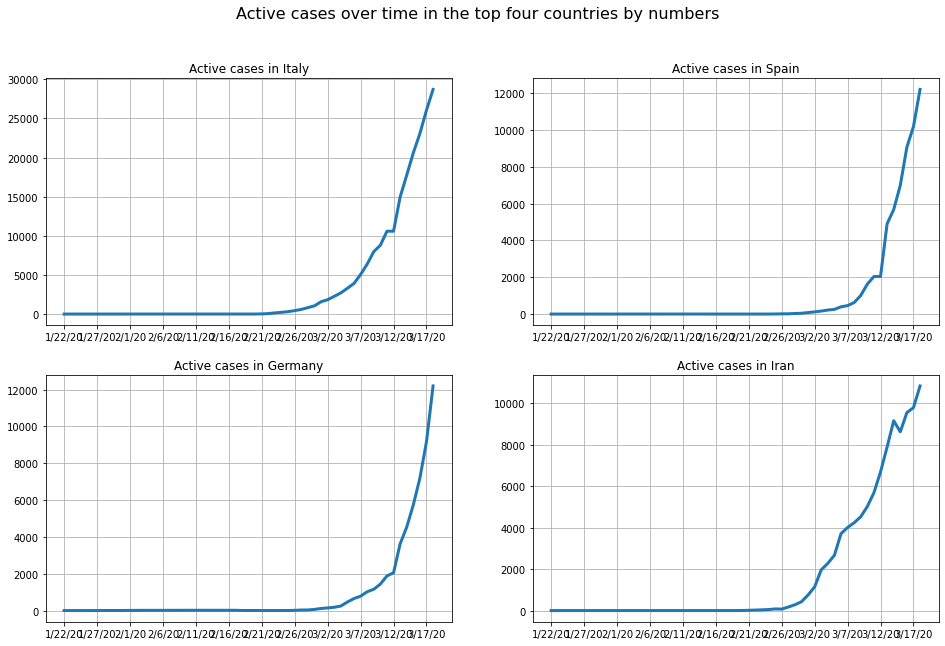

In [136]:
fig, ax = plt.subplots(2, 2, figsize=(16,10))

def plot_top4(da,num,xcol, ycol, title):
    ax[num].plot(da[xcol],da[ycol], lw=3)
    ax[num].set_title(title)
    ax[num].xaxis.set_major_locator(plt.MaxNLocator(13))
    ax[num].grid(True)
    
plot_top4(top_four_all, (0,0), "Date", top_four[0] + ' active', 'Active cases in {}'.format(top_four[0]))
plot_top4(top_four_all, (0,1), "Date", top_four[1] + ' active', 'Active cases in {}'.format(top_four[1]))
plot_top4(top_four_all, (1,0), "Date", top_four[2] + ' active', 'Active cases in {}'.format(top_four[2]))
plot_top4(top_four_all, (1,1), "Date", top_four[3] + ' active', 'Active cases in {}'.format(top_four[3]))
fig.suptitle('Active cases over time in the top four countries by numbers', fontsize=16)

plt.show()

As on 18.03, all of the top four countries with the most active cases are still in a steep slope of growth of cases with the exception of Iran, whose growth slope is getting gentler. 

We compare the curves above with the one from China, the country with the most reported cases so far but with a declining number of new positive cases. 
<br> We added also the graph from South Korea where the active cases are starting to drop since mif March.
<br> In both countries the peak of active cases shows in the graphs around a month since the curve starting to get up in the data of significant numbers of cases. Both countries took strict measures to content the spread of the virus including lockdowns of hotspots, social distancing, self-isolation and closing of public places and schools.

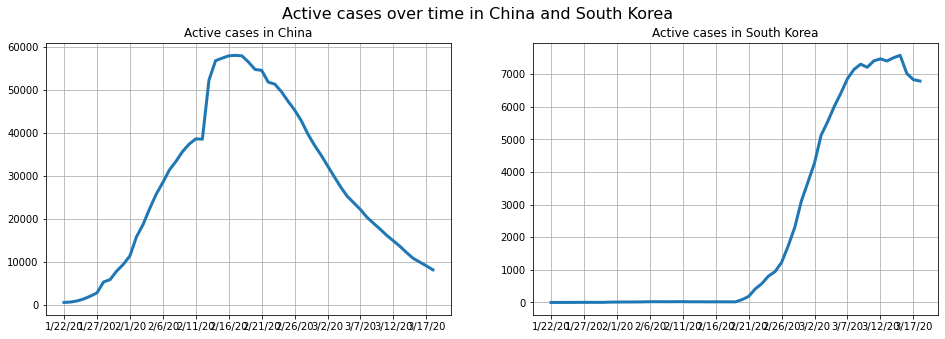

In [137]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
plot_top4(top_four_all, 0, "Date", 'China active', 'Active cases in China')
plot_top4(top_four_all, 1, "Date", 'South Korea active', 'Active cases in South Korea')
fig.suptitle('Active cases over time in China and South Korea', fontsize=16)

plt.show()

# Country Analysis - Italy

Import the latest reports from the Presidenza del Consiglio dei Ministri - Dipartimento della Protezione Civile. 
<br>Date of the latest data to be gathered is yesterday to ensure the data is available as the files are updated daily at midnight. 
<br>We use the date variable "ieri" to build the urls dynamically. The date format used in the Italian repository differs from the one used by the CSSE at Johns Hopkins University, this is why we need to build it.

In [138]:
ieri = date.today() - timedelta(days=1)
ieri = ieri.strftime("%Y%m%d")

In [139]:
nat_url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
reg_url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv"
reg_daily_url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni-{}.csv".format(ieri)
prov_url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv" 
da_national = get_raw_data(nat_url)
da_region = get_raw_data(reg_url)
da_daily_region = get_raw_data(reg_daily_url)
da_province = get_raw_data(prov_url)

We rename the columns to translate them to English.

In [140]:
da_national.columns

Index(['data', 'stato', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare',
       'totale_attualmente_positivi', 'nuovi_attualmente_positivi',
       'dimessi_guariti', 'deceduti', 'totale_casi', 'tamponi'],
      dtype='object')

In [141]:
da_national = da_national.rename(columns={'data':"timestamp", 'stato':"state", 
                            'ricoverati_con_sintomi':"hospitalized with symptoms", 
                            'terapia_intensiva':"intensive care",
                            'totale_ospedalizzati':"total hospitalized",
                            'isolamento_domiciliare':"self-isolation",
                            'totale_attualmente_positivi':"total currently positive", 
                            'nuovi_attualmente_positivi':"new positive",
                            'dimessi_guariti':"recovered", 
                            'deceduti':"fatalities", 
                            'totale_casi':"total positive", 
                            'tamponi':"total tested"})
da_national.head(2)

,timestamp,state,hospitalized with symptoms,intensive care,total hospitalized,self-isolation,total currently positive,new positive,recovered,fatalities,total positive,total tested
0,2020-02-24 18:00:00,ITA,101,26,127,94,221,221,1,7,229,4324
1,2020-02-25 18:00:00,ITA,114,35,150,162,311,90,1,10,322,8623


In [142]:
da_region = da_region.rename(columns={'data':"date", 'stato':"state", 'codice_regione':"regional code", 
                          'denominazione_regione':"region", 'ricoverati_con_sintomi':"hospitalized with symptoms", 
                          'terapia_intensiva':"intensive care",'totale_ospedalizzati':"total hospitalized", 
                          'isolamento_domiciliare':"self-isolation", 
                          'totale_attualmente_positivi':"total currently positive", 
                          'nuovi_attualmente_positivi':"new positive",'dimessi_guariti':"recovered", 
                          'deceduti':"fatalities", 'totale_casi':"total positive", 'tamponi':"total tested"})
da_region.head(2)

,date,state,regional code,region,lat,long,hospitalized with symptoms,intensive care,total hospitalized,self-isolation,total currently positive,new positive,recovered,fatalities,total positive,total tested
0,2020-02-24 18:00:00,ITA,13,Abruzzo,42.351222,13.398438,0,0,0,0,0,0,0,0,0,5
1,2020-02-24 18:00:00,ITA,17,Basilicata,40.639471,15.805148,0,0,0,0,0,0,0,0,0,0


In [143]:
da_daily_region = da_daily_region.rename(columns={'data':"date", 'stato':"state", 'codice_regione':"regional code", 
                          'denominazione_regione':"region", 'ricoverati_con_sintomi':"hospitalized with symptoms", 
                          'terapia_intensiva':"intensive care",'totale_ospedalizzati':"total hospitalized", 
                          'isolamento_domiciliare':"self-isolation", 
                          'totale_attualmente_positivi':"total currently positive", 
                          'nuovi_attualmente_positivi':"new positive",'dimessi_guariti':"recovered", 
                          'deceduti':"fatalities", 'totale_casi':"total positive", 'tamponi':"total tested"})
da_daily_region.head(2)

,date,state,regional code,region,lat,long,hospitalized with symptoms,intensive care,total hospitalized,self-isolation,total currently positive,new positive,recovered,fatalities,total positive,total tested
0,2020-03-18 17:00:00,ITA,13,Abruzzo,42.351222,13.398438,99,41,140,109,249,33,7,7,263,2054
1,2020-03-18 17:00:00,ITA,17,Basilicata,40.639471,15.805148,9,2,11,16,27,7,0,0,27,262


## Time trends on national level 

<function matplotlib.pyplot.show(*args, **kw)>

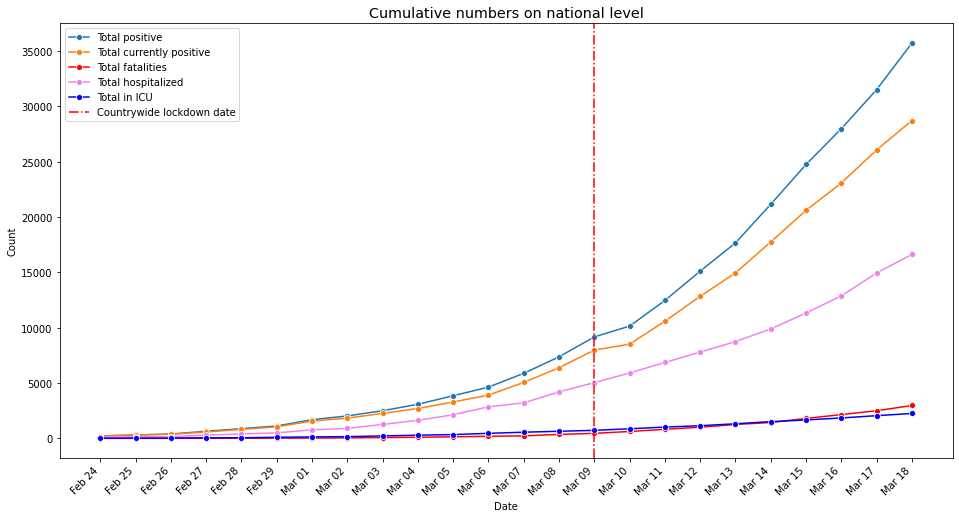

In [144]:
plt.figure(figsize=(16,8))
plt.title("Cumulative numbers on national level", size="x-large")
rng = da_national["timestamp"]
rng = [datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S').strftime("%b %d") for x in rng]
da_national["date"] = rng
sns.lineplot(x=da_national["date"], y=da_national["total positive"], 
             label = "Total positive", marker = "o")
sns.lineplot(x=da_national["date"], y=da_national["total currently positive"], 
             label = "Total currently positive", marker = "o")
sns.lineplot(x=da_national["date"], y=da_national["fatalities"], 
             label = "Total fatalities", marker = "o", color = "red")
sns.lineplot(x=da_national["date"], y=da_national["total hospitalized"], 
             label = "Total hospitalized", marker = "o", color="violet")
sns.lineplot(x=da_national["date"], y=da_national["intensive care"], 
             label = "Total in ICU", marker = "o", color="blue").set(xlabel = "Date", ylabel = "Count")
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light'  
)
plt.axvline(x="Mar 09", ls="-.", c="red", label = "Countrywide lockdown date")
plt.legend(fontsize="medium")
plt.show

Active cases keep growing rapidly on national level. Following the trends from China and South Korea, we could infere that this behaviour is expected until at least one month since the countrywide lockdown.

In [145]:
da_national.columns

Index(['timestamp', 'state', 'hospitalized with symptoms', 'intensive care',
       'total hospitalized', 'self-isolation', 'total currently positive',
       'new positive', 'recovered', 'fatalities', 'total positive',
       'total tested', 'date'],
      dtype='object')

## Country numbers in a nutshell

In [146]:
latest = da_national.loc[:,['total tested','total positive', 'total currently positive',
                            'recovered','self-isolation','total hospitalized',
                            'intensive care','fatalities']].tail(1)
latest["death rate [%]"] = 100*latest["fatalities"]/latest["total positive"]
latest.head()

,total tested,total positive,total currently positive,recovered,self-isolation,total hospitalized,intensive care,fatalities,death rate [%]
23,165541,35713,28710,4025,12090,16620,2257,2978,8.3387


In [147]:
ind = len(da_national) -1

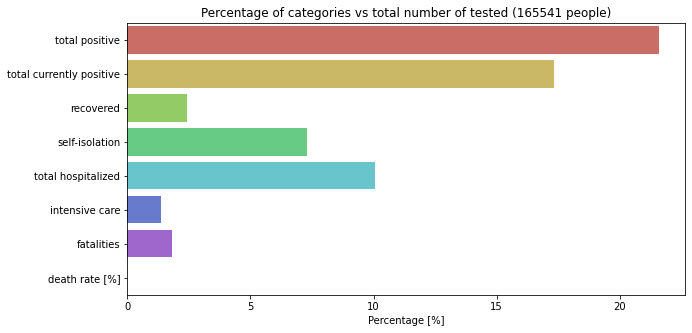

In [148]:
fig, ax = plt.subplots(figsize=(10,5))
plt.title("Percentage of categories vs total number of tested ({} people)".format(latest.loc[ind,"total tested"]), 
          size="large")
ax = sns.barplot(data=100*latest.loc[:,latest.columns != "total tested"]/latest.loc[ind,"total tested"], 
     orient="h",
     palette = 'hls').set(xlabel = "Percentage [%]")

From all tested population: 
<br>17.53% tested positive and are still active.
<br>10% have been hospitalized.
<br>1.7% have passed away.

## Analysis on regional level

In [149]:
da_daily_region["percentage of active [%]"] = round(100*da_daily_region[
                                    "total currently positive"]/latest.loc[ind,"total currently positive"],2)
da_daily_region["percentage of total positive [%]"] = round(
                                    100*da_daily_region["total positive"]/latest.loc[ind,"total positive"],2)

In [150]:
da_daily_region[["region","total tested","total positive","total currently positive",
                 "percentage of active [%]",
                 "percentage of total positive [%]"]].sort_values(
                 by="total currently positive", ascending=False).head(4)

,region,total tested,total positive,total currently positive,percentage of active [%],percentage of total positive [%]
9,Lombardia,48983,17713,12266,42.72,49.60
5,Emilia Romagna,15461,4525,3915,13.64,12.67
20,Veneto,40841,3214,2953,10.29,9.00
12,Piemonte,7516,2341,2187,7.62,6.56


In [151]:
fig = px.treemap(da_daily_region,
                 path=['region'],
                 values= da_daily_region['total positive'],
                 title='Regions with Active Cases in Italy: status {}'.format(ieri),
                 hover_data=['total positive', 'total currently positive', 'recovered','fatalities'],
                 color_discrete_sequence=px.colors.qualitative.Prism)
fig.show()

Lombardia is the region with the bigest share of cases with 45.42% of all cases and 42.13% of those currently active. 
<br>Emilia Romagna follows with 11.86% of the total cases and 11.01% of the currently active. 
<br>As the outbreak hit Lombardia first, the number of fatalities and recovered cases are higher, explaining the lower number of currently cases in comparison to the total of cases. 
<br>In the other regions, the outbreak started more recently, therefore the actual positive and total positive in those regions are very close to each other.

In [152]:
top_italy = da_daily_region.sort_values(by="total currently positive", ascending=False)["region"].head(4)

In [153]:
lomb_active_time = da_region[da_region["region"]=="Lombardia"][["date","total currently positive","fatalities","recovered"]]

<function matplotlib.pyplot.show(*args, **kw)>

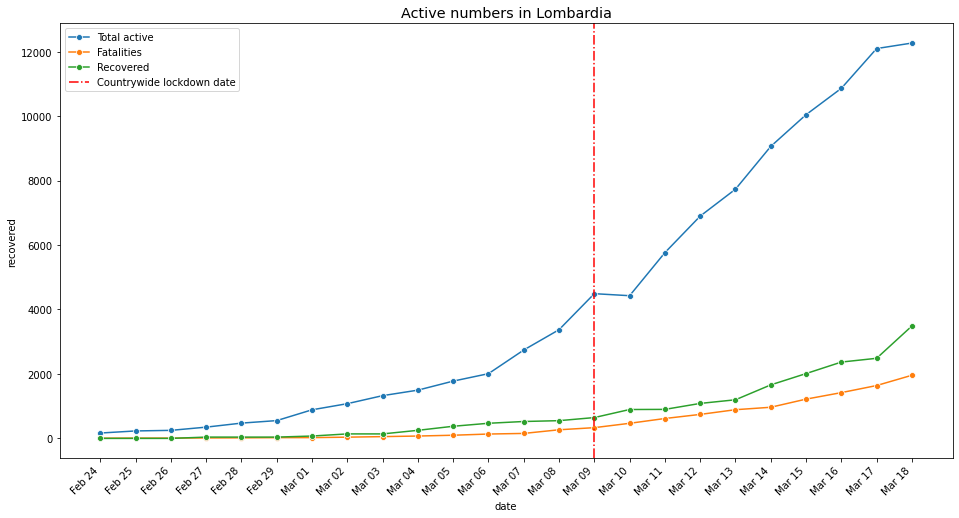

In [154]:
plt.figure(figsize=(16,8))
plt.title("Active numbers in Lombardia", size="x-large")
rng = lomb_active_time["date"]
rng = [datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S').strftime("%b %d") for x in rng]
lomb_active_time["date"] = rng
sns.lineplot(x=lomb_active_time["date"], y=lomb_active_time["total currently positive"], 
             label = "Total active", marker = "o")
sns.lineplot(x=lomb_active_time["date"], y=lomb_active_time["fatalities"], 
             label = "Fatalities", marker = "o")
sns.lineplot(x=lomb_active_time["date"], y=lomb_active_time["recovered"], 
             label = "Recovered", marker = "o")
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light'  
)
plt.axvline(x="Mar 09", ls="-.", c="red", label = "Countrywide lockdown date")
plt.legend(fontsize="medium")
plt.show